Uses a u-net implementation from https://arxiv.org/abs/1606.06650

# Setup

Install dependencies

In [1]:
!pip install --quiet --upgrade pip
!pip install --quiet unet==0.7.7
!pip install --quiet torchio==0.18.20
!pip install matplotlib --quiet
!pip install pyside2 --quiet
!pip install napari --quiet
!pip install seaborn --quiet
!pip install scikit-image --quiet

In [2]:
%gui qt

# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

train_whole_images = False 
train_patches = True

In [3]:
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
import pandas as pd

from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt
import napari

from IPython import display
from tqdm.notebook import tqdm
import seaborn as sns; sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()

print('TorchIO version:', tio.__version__)

TorchIO version: 0.18.20


Load subjects into dataset

Mount folder on google drive to access data

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# root_path = 'gdrive/MyDrive/mct_data/'

root_path = './'

histogram_landmarks_path = 'landmarks.npy'


In [5]:
data_dir = Path(root_path + 'data/')
image_paths = sorted(data_dir.glob('**/*image.nii.gz'))
label_paths = sorted(data_dir.glob('**/*label.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    mct = tio.ScalarImage(image_path)
    labels = tio.LabelMap(label_path, affine=mct.affine)
    subject = tio.Subject(
        mct=mct,
        labels=labels,
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 1 subjects


Let's take a look at one of the subjects in the dataset

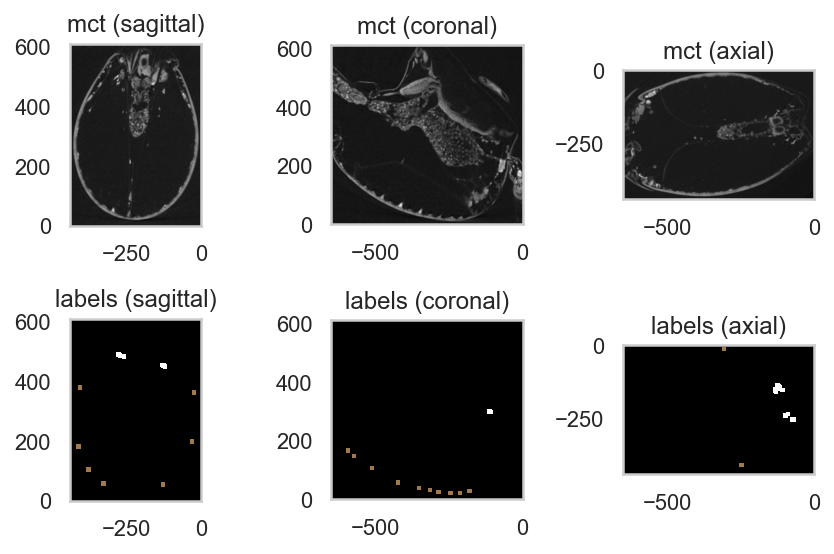

In [6]:
dataset[0].plot()

In [7]:
print(dataset[0].mct)

ScalarImage(shape: (1, 652, 441, 611); spacing: (1.00, 1.00, 1.00); orientation: LPS+; memory: 670.2 MiB; dtype: torch.IntTensor)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


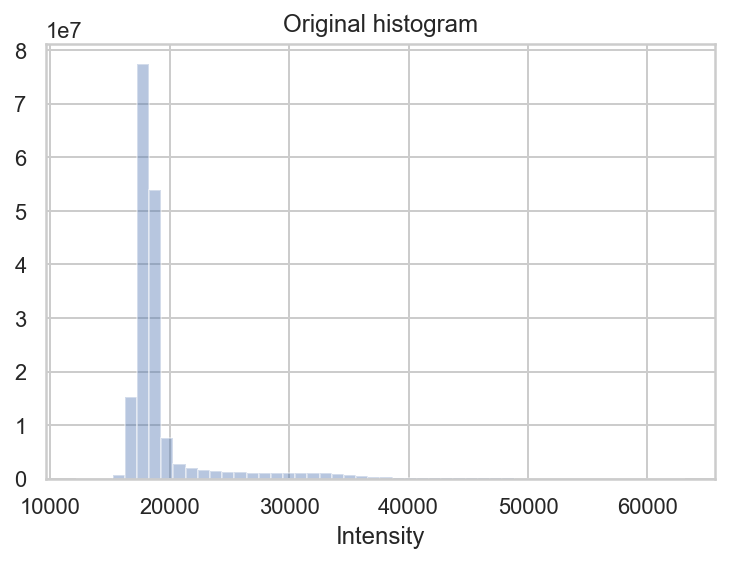

In [8]:
paths = image_paths

fig, axis = plt.subplots(1, 1)
tensor = tio.ScalarImage(paths[0]).data
color = 'black'
sns.distplot(tensor, ax=axis, kde=False)

axis.set_title('Original histogram')
axis.set_xlabel('Intensity')
axis.grid()


The intensity histogram looks like it needs some data normalisation

# Data Normalisation

I will use HistogramStandardisation (https://ieeexplore.ieee.org/document/836373) and the ZNormalization transforms to normalise image intensity

First, lets do histogram standardisation

In [9]:
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

100%|██████████| 1/1 [00:15<00:00, 15.59s/it]



Trained landmarks: [  0.      4.15    5.781   6.39    6.937   7.933   8.899   9.921  11.144
  11.944  13.054  26.443 100.   ]


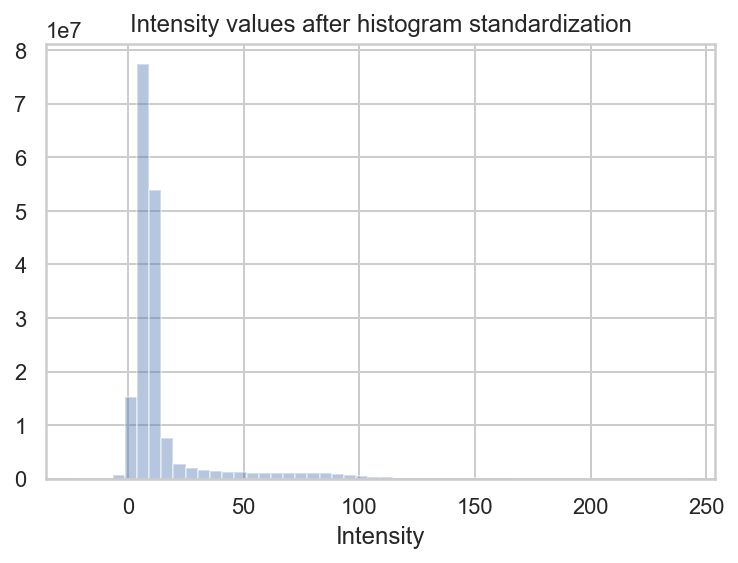

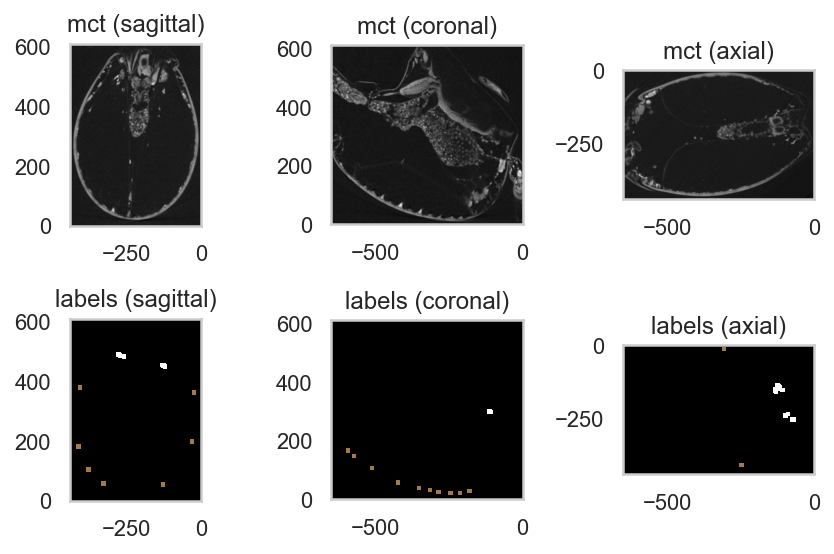

In [10]:
landmarks_dict = {'mct': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

fig, axis = plt.subplots(1, 1)

standard = histogram_transform(dataset[0])
tensor = standard.mct.data
sns.distplot(tensor, ax=axis, kde=False)

axis.set_title('Intensity values after histogram standardization')
axis.set_xlabel('Intensity')
axis.grid()
standard.plot()

Next, let's do Z-standardization or normalization. This means that our data will have zero mean and unit variance. We do this using mean and variance computer for each image, as opposed to the whole dataset, as mct values can vary a lot.

We have also only used foreground values to compute the mean and variance. The foreground has been approximated as all values above the mean, which should work well.

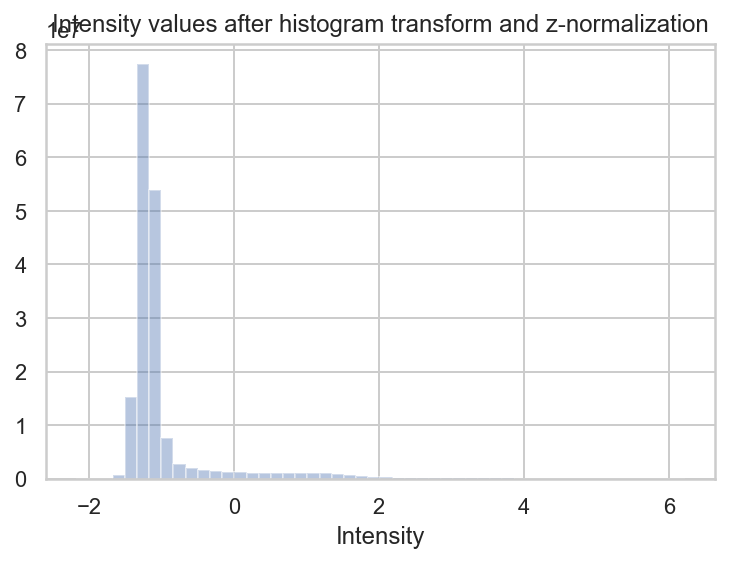

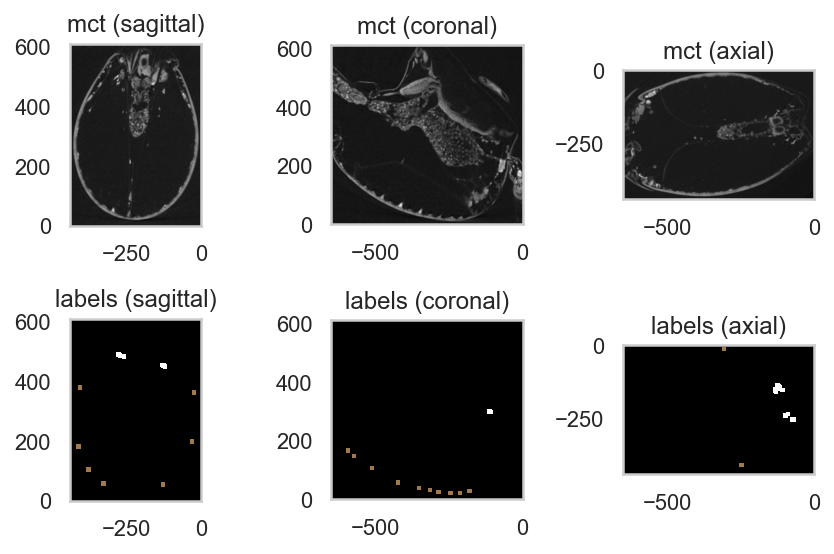

In [11]:
znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

sample = dataset[0]
transform = tio.Compose([histogram_transform, znorm_transform])
znormed = transform(sample)
tensor = znormed.mct.data

fig, axis = plt.subplots(1, 1)
sns.distplot(tensor, ax=axis, kde=False)
axis.set_title('Intensity values after histogram transform and z-normalization')
axis.set_xlabel('Intensity')
axis.grid()
znormed.plot()

The data also appears to have some outliers with very high intensity. It may be possible to get rid of those by rescaling intensity according to percentiles 

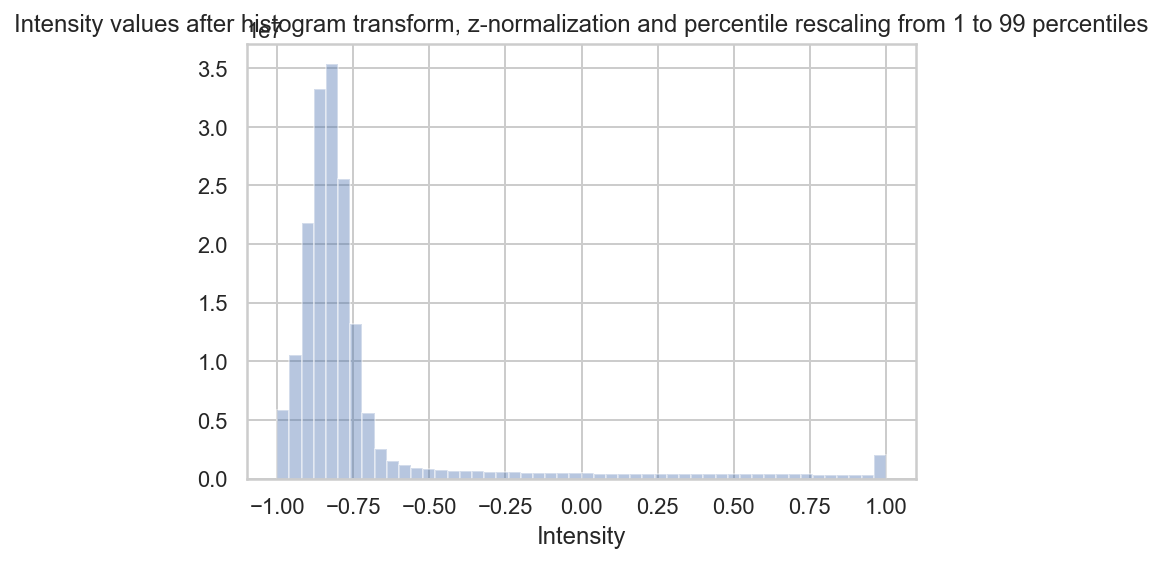

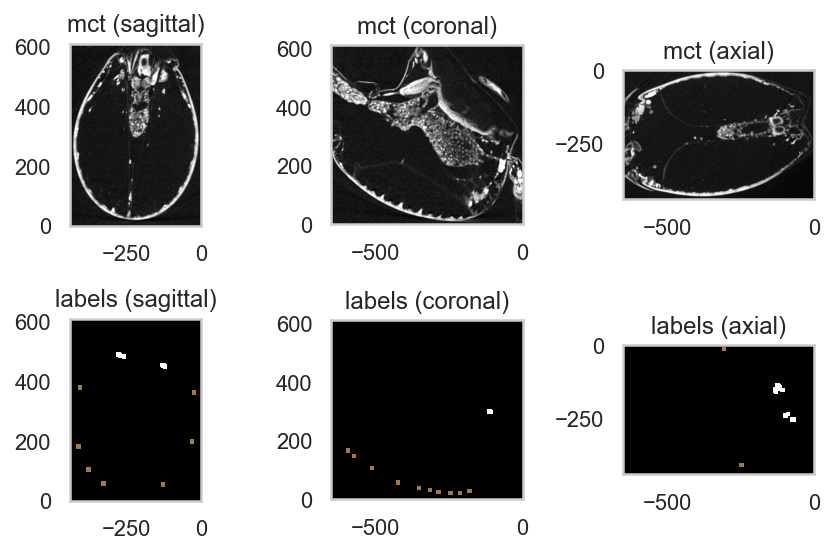

In [12]:
sample = dataset[0]
rescale = tio.RescaleIntensity((-1, 1), percentiles=(1, 99))
transform = tio.Compose([histogram_transform, znorm_transform, rescale])
rescaled = transform(sample)
tensor = rescaled.mct.data

fig, axis = plt.subplots(1, 1)
sns.distplot(tensor, ax=axis, kde=False)
axis.set_title('Intensity values after histogram transform, z-normalization and percentile rescaling from 1 to 99 percentiles')
axis.set_xlabel('Intensity')
axis.grid()
rescaled.plot()

Let's view our data in 3 dimensions


In [15]:
viewer = napari.Viewer()
viewer.dims.ndisplay = 3 # toggle 3 dimensional view
viewer.add_image(sample.mct.data.numpy())
viewer.add_image(rescaled.mct.data.numpy())

<Image layer 'Image [1]' at 0x1a5f02748>

In [16]:
# add labels
viewer.add_image(rescaled.labels.data.numpy())

<Image layer 'Image [2]' at 0x12cab20b8>

# Training

In [11]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.RandomMotion(p=0.2),
    tio.HistogramStandardization({'mct': landmarks}),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RescaleIntensity((-1, 1), percentiles=(1, 99)),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.HistogramStandardization({'mct': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RescaleIntensity((-1, 1), percentiles=(1, 99)),
    tio.OneHot(),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

ValueError: ignored

## deep learning functions

In [ ]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['mct'][tio.DATA].to(device)
    targets = batch['labels'][tio.DATA].to(device)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

## Patch-based approach

In [ ]:
training_batch_size = 32
validation_batch_size = 2 * training_batch_size

patch_size = 24
samples_per_volume = 5
max_queue_length = 300
sampler = tio.data.UniformSampler(patch_size)

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

Visualize axial slices of one batch

In [ ]:
one_batch = next(iter(training_loader_patches))
k = int(patch_size // 4)
batch_mct = one_batch['mct'][tio.DATA][..., k]
batch_label = one_batch['labels'][tio.DATA][:, 1:, ..., k]
slices = torch.cat((batch_mct, batch_label))
image_path = 'batch_patches.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=training_batch_size,
    normalize=True,
    scale_each=True,
)
display.Image(image_path)

### Train

In [ ]:
model, optimizer = get_model_and_optimizer(device)
weights_path = 'patches_state_dict.pth'

if train_patches:
    weights_stem = 'patches'
    train_losses, val_losses = train(
        num_epochs,
        training_loader_patches,
        validation_loader_patches,
        model,
        optimizer,
        weights_stem,
    )
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
else:
    weights_url = 'https://github.com/fepegar/torchio-data/raw/master/models/patches_epoch_5.pth'
    !curl --location --silent --output {weights_path} {weights_url}
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with patches (subvolumes)')
ax.legend()
fig.autofmt_xdate()

### Test

In [ ]:
subject = random.choice(validation_set)
input_tensor = sample.mct.data[0]
patch_size = 48, 48, 48  # we can user larger patches for inference
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['mct'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=CHANNELS_DIMENSION)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
affine = subject.mct.affine
prediction = tio.ScalarImage(tensor=foreground, affine=affine)
subject.add_image(prediction, 'prediction')
subject.plot(figsize=(9, 8), cmap_dict={'prediction': 'RdBu_r'})